In [1]:
# first party
import ast

# third party
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from torch.utils.data import DataLoader

# first party
from data import NBMEDataset, build_pseudo_data, load_training_data
from model import NBMEModel
from utils import (
    Configuration,
    build_pseudo_predictions,
    create_labels_for_scoring,
    get_character_probabilities,
    get_predictions,
    get_score,
    get_thresholded_sequences,
    training_function,
    validation_function,
)

/home/rydevera3/.virtualenvs/text-mining-titans/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/rydevera3/.virtualenvs/text-mining-titans/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the ass

In [2]:
config = Configuration()
data = pd.read_csv("./nbme_data/train_data_with_pseudo_labels.csv")
data["annotation"] = data["annotation"].apply(ast.literal_eval)
data["location"] = data["location"].apply(ast.literal_eval)

In [3]:
valid_df = data.loc[data["fold_number"] == 4].reset_index(drop=True)
valid_patient_notes_texts = valid_df["pn_history"].values
valid_labels = valid_df["location"].apply(create_labels_for_scoring)

# Create the datasets and data loaders
valid_dataset = NBMEDataset(valid_df, config)

# Training loaders
valid_loader = DataLoader(
    valid_dataset, batch_size=4, shuffle=False, pin_memory=True, drop_last=False
)

# Get the loss and optimizers and model
model = NBMEModel(config=config)
model.load_state_dict(torch.load('./models/deberta_v3_base_cpt_epoch_6.pt'))

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [4]:
# Get the probability outputs
device = torch.device('cuda:1')
model = model.to(device)
predictions, labels = validation_function(config, valid_loader, model, device)

715it [00:56, 12.67it/s]


In [5]:
import numpy as np

# Reshape the predictions and labels
samples = len(valid_df)
predictions = predictions.reshape((samples, config.max_length))
labels = labels.reshape((samples, config.max_length))

# Get character probabilities
character_probabilities = get_character_probabilities(
    valid_patient_notes_texts, predictions, config
)

# Get results
results = get_thresholded_sequences(character_probabilities)
preds = get_predictions(results)

In [6]:
# First we want to see the actuals vs the predictions
from utils import pseudo_label
label_preds = []
for pred in preds:
    locations = list(map(lambda x: f'{x[0]} {x[1]}', pred))
    label_preds.append(locations)
    
valid_df['predicted_location'] = label_preds

In [7]:
import spacy
from spacy import displacy

pn_num = 16
pn_num_mask = valid_df['pn_num'] == pn_num
df = valid_df.loc[pn_num_mask].reset_index(drop=True)

text = df['pn_history'].unique()[0]
features = df['feature_text'].tolist()
locations = df['location'].tolist()
predicted_locations = df['predicted_location'].tolist()

In [8]:
text

'HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with "thyroid disease," dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms'

In [9]:
from pathlib import Path

ents = []
for location, feature in zip(locations, features):
    if len(location) != 0:
        for i in location:
            start, end = i.split(' ')
            start, end = int(start), int(end)
            
            ents.append({'start': start, 'end': end, 'label': feature})
            
# Create the doc
colors = {
    "Annotation": "linear-gradient(90deg, darkviolet, palegreen)" 
}
doc = {'text': text, 'ents': ents}
options = {'colors': colors, 'distance': 200, 'word_spacing': 60}

svg = displacy.render(doc, manual=True, style='ent', options=options, jupyter=True, page=True)
# output_path = Path('./annotated_example.svg')
# output_path.open('w', encoding='utf-8').write(svg)

In [10]:
ents = []
for location, feature in zip(predicted_locations, features):
    if len(location) != 0:
        for i in location:
            start, end = i.split(' ')
            start, end = int(start), int(end)
            
            ents.append({'start': start, 'end': end, 'label': 'Annotation'})
            
# Create the doc
colors = {
    "Annotation": "lightblue" 
}
doc = {'text': text, 'ents': ents}
options = {'colors': colors}
displacy.render(doc, manual=True, style='ent', options=options)

In [11]:
from utils import get_score

In [12]:
valid_labels[0], preds[0]

([[696, 724]], [[696, 724]])

In [13]:
scores = []

text = valid_df['pn_history'].values
for label, pred, text in zip(valid_labels.tolist(), preds, text):
    score = None
    true_annotation = []
    predicted_annotation = []
    if len(label) != 0:
        score = get_score([label], [pred])
        for i in label:
            start, end = i
            annotation = text[start:end]
            true_annotation.append(annotation)
            
        for j in pred:
            start, end = j
            annotation = text[start:end]
            predicted_annotation.append(annotation)
            
    true_annotation = ', '.join(true_annotation)
    predicted_annotation = ', '.join(predicted_annotation)
        
    scores.append((score, true_annotation, predicted_annotation))

In [14]:
performance_df = pd.DataFrame(
    scores,
    columns=['f1_score', 'true_annotation', 'predicted_annotation']
)

In [15]:
performance_df.sort_values('f1_score').dropna().head(50)

,f1_score,true_annotation,predicted_annotation
1126,0.000000,no melena,
867,0.000000,M,
895,0.000000,GNOWING,
908,0.000000,in upper middle ABD,abdominal pain
1027,0.000000,M,
1058,0.000000,couple beers/wk,
1069,0.000000,melena,
1095,0.000000,episodes lasts 1-2 hours,
2079,0.000000,6M,6 MONTHS
2071,0.000000,F,


In [16]:
performance_df.iloc[829, :]

f1_score                                 0.25
true_annotation         sex only with husband
predicted_annotation                      sex
Name: 829, dtype: object

Text(0, 0.5, 'Frequency')

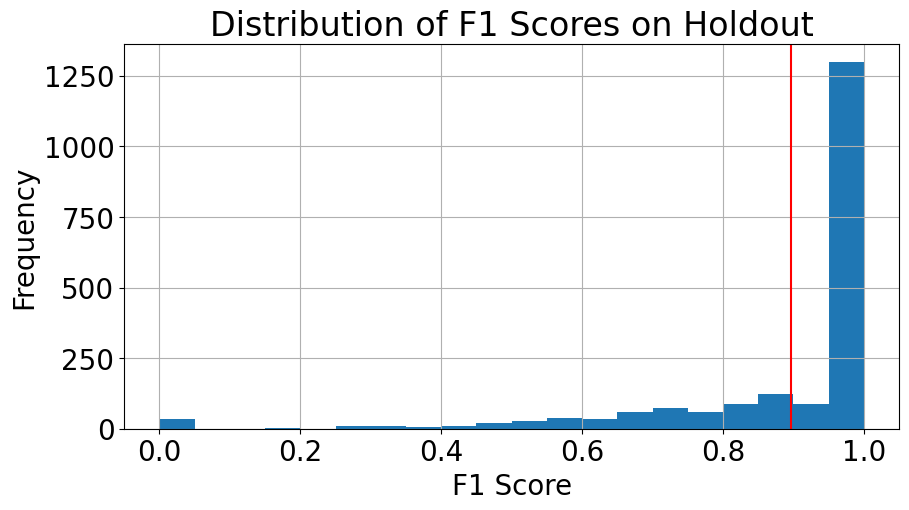

In [17]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

ax = performance_df['f1_score'].hist(figsize=(10, 5), bins=20)
ax.axvline(performance_df['f1_score'].mean(), color='red')
ax.set_title('Distribution of F1 Scores on Holdout')
ax.set_xlabel('F1 Score')
ax.set_ylabel('Frequency')

In [18]:
performance_df.loc[performance_df['f1_score'] < 0.90]

,f1_score,true_annotation,predicted_annotation
3,0.857143,"intermittent episodes, episode",intermittent episodes
9,0.795181,"palpitations, heart beating/pounding","palpitations, eart beating/pounding out of my ..."
16,0.473684,5-6 times,"happened 5-6 times, ntermittent"
22,0.674699,"pounding heart, pounding heart","rapid pounding heart rate, tachycardia, poundi..."
23,0.740741,"2-3 months, 2-3 months","for 2-3 months, over last 2-3 months"
...,...,...,...
2808,0.727273,feverish,Feels feverish
2811,0.545455,past day,day
2813,0.701754,Headache is all over,"headache, Headache is all over the head"
2827,0.705882,20 year odl,0 year


In [19]:
import transformers
import shap
import torch

In [20]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
index = 0  # 1885
text = valid_df['pn_history'].values[index]
feature_text = valid_df['feature_text'].values[index]
annotation = valid_df['annotation'].values[index]

In [22]:
inputs = tokenizer(
    text,
    feature_text,
    add_special_tokens=True,
    max_length=466,
    padding='max_length',
    return_offsets_mapping=False
)

for k, v in inputs.items():
    inputs[k] = torch.tensor(v, dtype=torch.long).reshape(1, 466)

In [23]:
data = [f'{text}[SEP]{feature_text}']
data

['HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with "thyroid disease," dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms[SEP]Family-history-of-MI-OR-Family-history-of-m

In [24]:
def make_annotation_scorer(annotation):
    def f(notes):
        out = []
        # There will be a bunch of masked notes created
        for n in notes:
            scores = []
            notes, feature = n.split("[SEP]")
            inputs = tokenizer(
                text,
                feature_text,
                add_special_tokens=True,
                max_length=466,
                padding='max_length',
                return_offsets_mapping=False
            )
            
            for k, v in inputs.items():
                inputs[k] = torch.tensor(v, dtype=torch.long, device=device).reshape(1, 466)

            predictions = model(inputs)
            predictions = torch.sigmoid(predictions.flatten())
            predictions = predictions.reshape((1, 466)).detach().cpu()
            
            character_probabilities = get_character_probabilities(
                [notes], predictions, config
            )
            results = get_thresholded_sequences(character_probabilities)
            preds = get_predictions(results)
            score = get_score(annotation['labels'], preds)
            scores.append(score)
            out.append(scores)
            
        return out
    
    f.output_names = annotation['annotation']
    return f

annotations = {
    'labels': [valid_labels[index]],
    'annotation': annotation,
}
f_annotation = make_annotation_scorer(annotation=annotations)

In [25]:
import matplotlib.pyplot as plt

explainer_answers = shap.Explainer(f_annotation, tokenizer)
shap_values_answers = explainer_answers(data)

Partition explainer: 2it [00:15, 15.84s/it]                                                                                                                                                                     


In [26]:
shap.plots.text(shap_values_answers, display=True)